# 🎯 Train Unified Classifier for 19 Classes

Hệ thống nhận diện chữ số viết tay và hình học:
- **10 chữ số**: 0-9 (MNIST)
- **9 hình học**: Circle, Triangle, Square, Pentagon, Hexagon, Heptagon, Octagon, Nonagon, Star

## Cải tiến mới:
- ✅ INPUT_SIZE: 64 → **128** (để phân biệt Circle/Nonagon/Octagon tốt hơn)
- ✅ Augmentation cân bằng: Rotation 30°, Perspective (0.1), ColorJitter (0.2) - **Giảm để giữ shape edges**
- ✅ Training: 20 epochs

---


In [1]:
# Import Libraries
import os
import argparse
import json
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")


✅ PyTorch version: 2.5.1+cu121
✅ CUDA available: True
✅ GPU: NVIDIA GeForce RTX 4050 Laptop GPU


## 📋 Configuration


In [2]:
class Config:
    # Paths
    MNIST_TRAIN_DIR = 'mnist_competition/train'
    MNIST_TRAIN_CSV = 'mnist_competition/train_label.csv'
    SHAPES_DIR = 'Shapes_Classifier/dataset/output'
    
    # Training
    EPOCHS = 20  # Increased from 10
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-4
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Model
    NUM_CLASSES = 19
    INPUT_SIZE = 128  # Increased from 64 to better distinguish high-edge shapes
    
    # Output
    MODEL_PATH = 'unified_model_19classes_best.pth'
    LABEL_MAPPING_PATH = 'label_mapping.json'

print("="*60)
print("CONFIGURATION")
print("="*60)
print(f"Device: {Config.DEVICE}")
print(f"Epochs: {Config.EPOCHS}")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Learning rate: {Config.LEARNING_RATE}")
print(f"Input size: {Config.INPUT_SIZE}x{Config.INPUT_SIZE}")
print(f"Num classes: {Config.NUM_CLASSES}")
print("="*60)


CONFIGURATION
Device: cuda
Epochs: 20
Batch size: 64
Learning rate: 0.0001
Input size: 128x128
Num classes: 19


## 📦 Dataset Class


In [3]:
class UnifiedDataset(Dataset):
    """Unified dataset for MNIST digits and geometric shapes."""
    
    def __init__(self, mnist_df, shapes_df, mnist_dir, shapes_dir,
                 shape_to_id, transform=None, sample_fraction=0.67):
        """
        Args:
            mnist_df: DataFrame with MNIST data
            shapes_df: DataFrame with shapes data
            mnist_dir: Directory with MNIST images
            shapes_dir: Directory with shape images
            shape_to_id: Mapping from shape name to class ID (10-18)
            transform: Image transforms
            sample_fraction: Fraction of shapes to use (balance with MNIST)
        """
        # Sample shapes to balance dataset
        shapes_df_sampled = shapes_df.sample(frac=sample_fraction, random_state=42)
        
        self.data_list = []
        
        # Add MNIST data (labels 0-9)
        for idx, row in mnist_df.iterrows():
            self.data_list.append({
                'path': os.path.join(mnist_dir, row['image_name']),
                'label': int(row['label']),
                'source': 'mnist'
            })
        
        # Add shapes data (labels 10-18)
        for idx, row in shapes_df_sampled.iterrows():
            self.data_list.append({
                'path': os.path.join(shapes_dir, row['image_name']),
                'label': shape_to_id[row['label']],
                'source': 'shape'
            })
        
        self.transform = transform
        
        print(f"✅ Dataset created: {len(self.data_list)} images")
        print(f"   - MNIST: {len(mnist_df)} images (classes 0-9)")
        print(f"   - Shapes: {len(shapes_df_sampled)} images (classes 10-18)")
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        item = self.data_list[idx]
        image = Image.open(item['path']).convert('L')
        
        # Apply preprocessing (CLAHE for contrast enhancement)
        # Convert PIL to numpy for OpenCV processing
        img_array = np.array(image)
        
        # Apply CLAHE for better contrast (especially for real-world images)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
        img_enhanced = clahe.apply(img_array)
        
        # Convert back to PIL
        image = Image.fromarray(img_enhanced)
        
        if self.transform:
            image = self.transform(image)
        
        return image, item['label']

print("✅ UnifiedDataset class defined")


✅ UnifiedDataset class defined


## 🏋️ Training Functions


In [4]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f"{running_loss/(pbar.n+1):.4f}",
            'acc': f"{100.*correct/total:.2f}%"
        })
    
    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    """Validate model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'loss': f"{running_loss/(pbar.n+1):.4f}",
                'acc': f"{100.*correct/total:.2f}%"
            })
    
    return running_loss / len(loader), 100. * correct / total

print("✅ Training functions defined")


✅ Training functions defined


## 📊 Load Data


In [5]:
print("Loading datasets...")

# Load MNIST
mnist_df = pd.read_csv(Config.MNIST_TRAIN_CSV)
print(f"✅ MNIST: {len(mnist_df)} images")

# Load Shapes
shape_files = [f for f in os.listdir(Config.SHAPES_DIR) if f.endswith('.png')]
shape_labels = [f.split('_')[0] for f in shape_files]
shapes_df = pd.DataFrame({'image_name': shape_files, 'label': shape_labels})
print(f"✅ Shapes: {len(shapes_df)} images")

# Create label mapping
shape_names = sorted(shapes_df['label'].unique())
shape_to_id = {name: idx + 10 for idx, name in enumerate(shape_names)}
id_to_label = {i: str(i) for i in range(10)}
id_to_label.update({v: k for k, v in shape_to_id.items()})

print(f"\n📋 Label Mapping:")
for class_id, label_name in sorted(id_to_label.items()):
    print(f"   Class {class_id:2d}: {label_name}")

# Save label mapping
with open(Config.LABEL_MAPPING_PATH, 'w') as f:
    json.dump(id_to_label, f, indent=2)
print(f"\n✅ Saved {Config.LABEL_MAPPING_PATH}")


Loading datasets...
✅ MNIST: 60000 images
✅ Shapes: 90000 images

📋 Label Mapping:
   Class  0: 0
   Class  1: 1
   Class  2: 2
   Class  3: 3
   Class  4: 4
   Class  5: 5
   Class  6: 6
   Class  7: 7
   Class  8: 8
   Class  9: 9
   Class 10: Circle
   Class 11: Heptagon
   Class 12: Hexagon
   Class 13: Nonagon
   Class 14: Octagon
   Class 15: Pentagon
   Class 16: Square
   Class 17: Star
   Class 18: Triangle

✅ Saved label_mapping.json


## 🔄 Data Transforms & Augmentation

**Cải tiến mới:**
- Resize: 64x64 → **128x128**
- RandomRotation: 15° → **30°**
- RandomAffine translate: 0.1 → **0.15**
- **NEW:** RandomPerspective (distortion=0.2)
- **NEW:** ColorJitter (brightness & contrast)
- **NEW:** CLAHE preprocessing (contrast enhancement) - Applied in Dataset.__getitem__()


In [6]:
# Transforms: Grayscale → RGB, Resize to 128x128 with stronger augmentation
train_transform = transforms.Compose([
    transforms.Resize((Config.INPUT_SIZE, Config.INPUT_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(30),  # Increased from 15
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),  # Increased from 0.1
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Added perspective transform
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # Added color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((Config.INPUT_SIZE, Config.INPUT_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Split data
mnist_train, mnist_val = train_test_split(
    mnist_df, test_size=0.15, random_state=42, stratify=mnist_df['label']
)
shapes_train, shapes_val = train_test_split(
    shapes_df, test_size=0.15, random_state=42, stratify=shapes_df['label']
)

print(f"📊 Data Split:")
print(f"   Train: MNIST {len(mnist_train)} + Shapes ~{int(len(shapes_train)*0.67)}")
print(f"   Val:   MNIST {len(mnist_val)} + Shapes ~{int(len(shapes_val)*0.67)}")


📊 Data Split:
   Train: MNIST 51000 + Shapes ~51255
   Val:   MNIST 9000 + Shapes ~9045


## 🎲 Create Datasets & DataLoaders


In [7]:
# Create datasets
train_dataset = UnifiedDataset(
    mnist_train, shapes_train,
    Config.MNIST_TRAIN_DIR, Config.SHAPES_DIR,
    shape_to_id, transform=train_transform,
    sample_fraction=0.67
)

val_dataset = UnifiedDataset(
    mnist_val, shapes_val,
    Config.MNIST_TRAIN_DIR, Config.SHAPES_DIR,
    shape_to_id, transform=val_transform,
    sample_fraction=0.67
)

# DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=Config.BATCH_SIZE,
    shuffle=True, num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=Config.BATCH_SIZE,
    shuffle=False, num_workers=0, pin_memory=True
)

print(f"\n✅ DataLoaders ready")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")


✅ Dataset created: 102255 images
   - MNIST: 51000 images (classes 0-9)
   - Shapes: 51255 images (classes 10-18)
✅ Dataset created: 18045 images
   - MNIST: 9000 images (classes 0-9)
   - Shapes: 9045 images (classes 10-18)

✅ DataLoaders ready
   Train batches: 1598
   Val batches: 282


## 🧠 Load Model: EfficientNet-B0


In [8]:
print("Loading EfficientNet-B0...")
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Modify classifier for 19 classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, Config.NUM_CLASSES)
model = model.to(Config.DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model ready")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model on device: {next(model.parameters()).device}")


Loading EfficientNet-B0...
✅ Model ready
   Total parameters: 4,031,887
   Trainable parameters: 4,031,887
   Model on device: cuda:0


## ⚙️ Training Setup


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

print(f"✅ Training setup complete")
print(f"   Criterion: CrossEntropyLoss")
print(f"   Optimizer: Adam (lr={Config.LEARNING_RATE})")
print(f"   Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")


✅ Training setup complete
   Criterion: CrossEntropyLoss
   Optimizer: Adam (lr=0.0001)
   Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)


c:\Users\Vu The Van\anaconda3\envs\httt\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 🚀 Training Loop

**⚠️ Warning:** This will take ~30-60 minutes depending on your GPU!


In [10]:
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("="*60)
print("STARTING TRAINING")
print("="*60 + "\n")

for epoch in range(Config.EPOCHS):
    print(f"\nEpoch {epoch+1}/{Config.EPOCHS}")
    print("-" * 60)
    
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, Config.DEVICE
    )
    val_loss, val_acc = validate(
        model, val_loader, criterion, Config.DEVICE
    )
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step(val_acc)
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'label_mapping': id_to_label,
            'config': {
                'epochs': Config.EPOCHS,
                'batch_size': Config.BATCH_SIZE,
                'lr': Config.LEARNING_RATE,
                'input_size': Config.INPUT_SIZE
            }
        }, Config.MODEL_PATH)
        print(f"✅ Saved best model: {Config.MODEL_PATH} (Val Acc: {val_acc:.2f}%)")

print(f"\n{'='*60}")
print(f"TRAINING COMPLETED!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Model saved: {Config.MODEL_PATH}")
print(f"{'='*60}")


STARTING TRAINING


Epoch 1/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [04:08<00:00,  1.14it/s, loss=0.0981, acc=95.83%]



Train Loss: 0.3933 | Train Acc: 86.71%
Val Loss: 0.0981 | Val Acc: 95.83%
✅ Saved best model: unified_model_19classes_best.pth (Val Acc: 95.83%)

Epoch 2/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:42<00:00,  6.59it/s, loss=0.0751, acc=96.87%]



Train Loss: 0.1306 | Train Acc: 95.03%
Val Loss: 0.0751 | Val Acc: 96.87%
✅ Saved best model: unified_model_19classes_best.pth (Val Acc: 96.87%)

Epoch 3/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:39<00:00,  7.08it/s, loss=0.0738, acc=97.10%]



Train Loss: 0.1027 | Train Acc: 96.02%
Val Loss: 0.0738 | Val Acc: 97.10%
✅ Saved best model: unified_model_19classes_best.pth (Val Acc: 97.10%)

Epoch 4/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [01:02<00:00,  4.52it/s, loss=0.0442, acc=98.33%]



Train Loss: 0.0856 | Train Acc: 96.63%
Val Loss: 0.0442 | Val Acc: 98.33%
✅ Saved best model: unified_model_19classes_best.pth (Val Acc: 98.33%)

Epoch 5/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:37<00:00,  7.62it/s, loss=0.0547, acc=97.62%]



Train Loss: 0.0773 | Train Acc: 96.97%
Val Loss: 0.0547 | Val Acc: 97.62%

Epoch 6/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [03:01<00:00,  1.56it/s, loss=0.0439, acc=97.95%]



Train Loss: 0.0713 | Train Acc: 97.27%
Val Loss: 0.0439 | Val Acc: 97.95%

Epoch 7/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:37<00:00,  7.55it/s, loss=0.0407, acc=98.26%]



Train Loss: 0.0654 | Train Acc: 97.44%
Val Loss: 0.0407 | Val Acc: 98.26%

Epoch 8/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:37<00:00,  7.59it/s, loss=0.0300, acc=98.76%]



Train Loss: 0.0561 | Train Acc: 97.77%
Val Loss: 0.0300 | Val Acc: 98.76%
✅ Saved best model: unified_model_19classes_best.pth (Val Acc: 98.76%)

Epoch 9/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:38<00:00,  7.38it/s, loss=0.0294, acc=98.88%]



Train Loss: 0.0516 | Train Acc: 97.95%
Val Loss: 0.0294 | Val Acc: 98.88%
✅ Saved best model: unified_model_19classes_best.pth (Val Acc: 98.88%)

Epoch 10/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:35<00:00,  7.84it/s, loss=0.0270, acc=98.91%]



Train Loss: 0.0511 | Train Acc: 97.98%
Val Loss: 0.0270 | Val Acc: 98.91%
✅ Saved best model: unified_model_19classes_best.pth (Val Acc: 98.91%)

Epoch 11/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:37<00:00,  7.51it/s, loss=0.0244, acc=99.03%]



Train Loss: 0.0489 | Train Acc: 98.04%
Val Loss: 0.0244 | Val Acc: 99.03%
✅ Saved best model: unified_model_19classes_best.pth (Val Acc: 99.03%)

Epoch 12/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:37<00:00,  7.50it/s, loss=0.0306, acc=98.70%]



Train Loss: 0.0483 | Train Acc: 98.06%
Val Loss: 0.0306 | Val Acc: 98.70%

Epoch 13/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:38<00:00,  7.35it/s, loss=0.0270, acc=98.84%]



Train Loss: 0.0470 | Train Acc: 98.17%
Val Loss: 0.0270 | Val Acc: 98.84%

Epoch 14/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:36<00:00,  7.70it/s, loss=0.0238, acc=99.07%]



Train Loss: 0.0460 | Train Acc: 98.14%
Val Loss: 0.0238 | Val Acc: 99.07%
✅ Saved best model: unified_model_19classes_best.pth (Val Acc: 99.07%)

Epoch 15/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:37<00:00,  7.61it/s, loss=0.0255, acc=98.99%]



Train Loss: 0.0441 | Train Acc: 98.26%
Val Loss: 0.0255 | Val Acc: 98.99%

Epoch 16/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:36<00:00,  7.79it/s, loss=0.0236, acc=99.12%]



Train Loss: 0.0436 | Train Acc: 98.26%
Val Loss: 0.0236 | Val Acc: 99.12%
✅ Saved best model: unified_model_19classes_best.pth (Val Acc: 99.12%)

Epoch 17/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:37<00:00,  7.62it/s, loss=0.0217, acc=99.09%]



Train Loss: 0.0433 | Train Acc: 98.28%
Val Loss: 0.0217 | Val Acc: 99.09%

Epoch 18/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:35<00:00,  7.88it/s, loss=0.0233, acc=99.04%]



Train Loss: 0.0418 | Train Acc: 98.30%
Val Loss: 0.0233 | Val Acc: 99.04%

Epoch 19/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:36<00:00,  7.66it/s, loss=0.0247, acc=99.02%]



Train Loss: 0.0411 | Train Acc: 98.38%
Val Loss: 0.0247 | Val Acc: 99.02%

Epoch 20/20
------------------------------------------------------------


Validation: 100%|██████████| 282/282 [00:36<00:00,  7.65it/s, loss=0.0205, acc=99.23%]



Train Loss: 0.0381 | Train Acc: 98.47%
Val Loss: 0.0205 | Val Acc: 99.23%
✅ Saved best model: unified_model_19classes_best.pth (Val Acc: 99.23%)

TRAINING COMPLETED!
Best Validation Accuracy: 99.23%
Model saved: unified_model_19classes_best.pth


## 📈 Visualize Training History


✅ Saved training_history.png


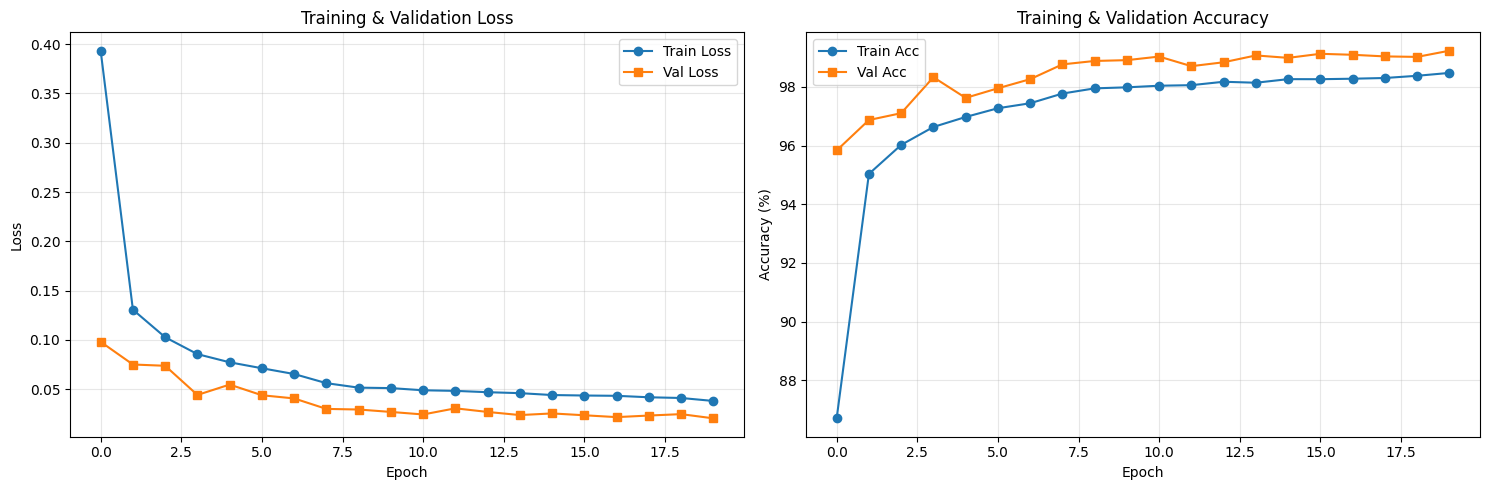

In [11]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Accuracy
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training & Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
print("✅ Saved training_history.png")
plt.show()


## 🎯 Next Steps

After training completes, run evaluation:

```python
# Run this in terminal or new notebook
!python evaluate_model.py
```

Expected improvements:
- **Circle accuracy**: 76% → **>90%** ✨
- **Nonagon accuracy**: 73% → **>85%** ✨
- **Octagon accuracy**: 70% → **>85%** ✨

Then test on your sample image:

```python
!python pipeline.py --image Shapes_Classifier/Sample.png --output Sample_result_new.png
```

---

**✅ Training notebook created successfully!**
